In [0]:
#installing aws cli
!curl "https://d1vvhvl2y92vvt.cloudfront.net/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
!unzip awscliv2.zip
!sudo ./aws/install

In [ ]:
#enter your aws key and secret key
!/usr/local/bin/aws2 configure

In [0]:
#display path of aws
!/usr/local/bin/aws2 s3 ls spacenet-dataset/AOIs/AOI_1_Rio/processedData/

                           PRE vectorData/
2019-07-30 20:44:33 2557224243 3band.tar.gz
2019-07-30 20:45:35  888770741 8band.tar.gz
2019-07-30 20:46:02 3564638448 processedBuildingLabels.tar.gz
2019-07-30 20:47:42  151688181 vectorData.tar.gz


In [0]:
#download from AWS
!/usr/local/bin/aws2 s3api get-object --bucket spacenet-dataset \
    --key AOIs/AOI_1_Rio/processedData/8band.tar.gz \
    --request-payer requester /content/drive/'My Drive'/spacenet-data/8band.tar.gz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = "/content/drive/My Drive/spacenet-data/"

In [0]:
import tarfile

In [0]:
#unzipping geojson label files
vector_tar = tarfile.open(drive_path + 'vectorData.tar.gz', "r:gz")
vector_tar.extractall()
vector_tar.close()

geojson_tar = tarfile.open('vectorData/geoJson.tar.gz', "r:gz")
geojson_tar.extractall()
geojson_tar.close()

In [0]:
#unzipping 3band and 8band images
images_tar = tarfile.open(drive_path + '8band.tar.gz')
images_tar.extractall()
images_tar.close()

images_tar = tarfile.open(drive_path + '3band.tar.gz')
images_tar.extractall()
images_tar.close()

In [0]:
!pip install rasterio
from osgeo import gdal
import json
from shapely.geometry import Polygon, shape, Point
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import rasterio

In [0]:
#converts pixel coordinates to lat long coordinates
def get_coords(map_image, pixel_x, pixel_y):
  coords = map_image.xy(pixel_x, pixel_y)
  return coords[0], coords[1]

In [0]:
#plot band image and distance transform
def plot_image(raster_file, distance_transform):
  raster = gdal.Open(raster_file)
  raster = raster.ReadAsArray()
  fg, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 10))

  ax1.imshow(raster[0])
  ax2.imshow(distance_transform)
  plt.show()

In [0]:
#image file: 3band_013022223130_Public_img1.tif
#json file: 013022223130_Public_img1_Geo.geojson

def apply_distance_transform(raster_image_name):
  #reading .tif image file
  raster = gdal.Open(raster_image_name)
  trans = raster.GetGeoTransform()

  #name of corresponding geojson file
  json_file = raster_image_name[raster_image_name.find('_') + 1:raster_image_name.find('.')] + '_Geo.geojson'
  print("json file: ",json_file)
  
  #applying distance transformation for all the points in the raster image.
  with rasterio.open(raster_image_name) as map_image:
    with open('geoJson/' + json_file, 'r') as f:
      geo_json = json.load(f)
      dist = np.zeros((raster.RasterXSize, raster.RasterYSize))

      for x in range(raster.RasterXSize):
        for y in range(raster.RasterYSize):
          point = Point(get_coords(map_image, x, y))

          #calculating distance from boundary to point
          distance = -100000.0
          for feature in geo_json['features']:
            polygon = shape(feature['geometry'])
            dist_boundary = point.distance(polygon.boundary)

            if polygon.contains(point) == False:
                dist_boundary = -1.0 * dist_boundary
            else:
                dist_boundary = 0

            if dist_boundary > distance :
                     distance = dist_boundary
          #distance transformation
          dist[x,y] = distance
  return dist

In [0]:
file_name = '8band/8band_013022223130_Public_img70.tif'
distance_map = apply_distance_transform(file_name)

json file:  013022223130_Public_img70_Geo.geojson


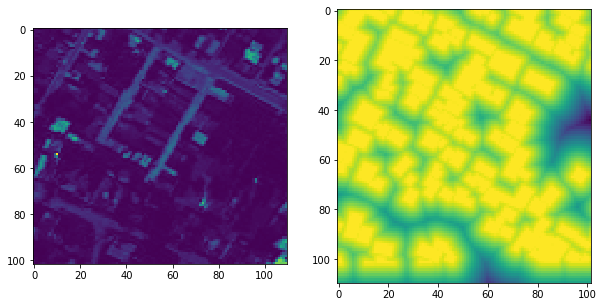

In [0]:
plot_image(file_name, distance_map)